Classification 2:
* Dataset: http://ai.stanford.edu/~amaas/data/sentiment/
* Target: pos/neg folders
* Metric: AUC-ROC
* Libraries: scikit‑learn + NLTK
* Text preprocessing – 3
    - Removing stop words
    - Stemming / Lemmatization
    - Bag of words / TF-IDF
    - N-grams
* Words importance - 2
* Hyperparameters tuning – 1
* Compare performance of models: SGDClassifier; SVM; Naive Bayes - 2

Некий план:
* придумать как в gs вычислять три метрики сразу
* придумать как в gs вместо кросс-валидации использовать тестовую выборку?
* заценить оригинальную статью
* text preprocessing
* feature engineering
* words importance?
* pipeline with sgd/svm/bayes + gridsearch

Прочитаем README:
* по 25к файлов на train/test, по 12.5к файлов на pos/neg
* pos – рейтинг >= 7, neg – рейтинг <= 4
* в название файлов включен рейтинг
* есть отдельный файл со ссылками на imdb, т.е. известно, какому фильму принадлежат рейтинги
* но толку от этого предположительно нуль, потому что фильмы в train/test не повторяются
* есть авторский bag of words в libsvm формате

Заменим тысячи файлов двумя train.json + test.json, куда включим собственно отзывы, таргет, рейтинг, и идентификатор фильма

In [1]:
import os
import json
from tqdm import tnrange, tqdm_notebook

In [2]:
def sample2json(sample):
    if sample not in ['train', 'test']:
        raise ValueError
    
    data = []
    for target in tqdm_notebook(['pos', 'neg'], desc='target', leave=False):
        with open('data/imdb/%s/urls_%s.txt' % (sample, target)) as file:
            urls = file.readlines()

        for index, filename in tqdm_notebook(enumerate(os.listdir('data/imdb/%s/%s' % (sample, target))), desc='file', leave=False):
            file_id, rating = filename.split('_')
            rating = rating[:rating.index('.')]
            
            with open('data/imdb/%s/%s/%s' % (sample, target, filename)) as file:
                data.append({
                    'file_id': file_id,
                    'rating': int(rating),
                    'review': file.read(),
                    'film_id': urls[index][28:35],
                    'target': target
                })
    
        with open('data/imdb/%s.json' % sample, 'w') as file:
            json.dump(data, file, indent=4)

In [3]:
for sample in tqdm_notebook(['train', 'test'], desc='sample'):
    if not os.path.exists('data/imdb/%s.json' % sample):
        sample2json(sample)

Чудно, займемся делом. Импортируем библиотеки

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pipelinehelper import PipelineHelper

А также чудесные jsonы

In [5]:
train = json.load(open('data/imdb/train.json'))
test = json.load(open('data/imdb/test.json'))
X_train = [item['review'] for item in train]
y_train = [int(item['target'] == 'pos') for item in train]
X_test = [item['review'] for item in test]
y_test = [int(item['target'] == 'pos') for item in test]

Построим [baseline](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html). Однако для этого используем в некоем смысле универсальный Pipeline, используя на последнем шаге три разных классификатора при помощи [pipelinehelper](https://github.com/bmurauer/pipelinehelper). ~~также см [класс](http://www.davidsbatista.net/blog/2018/02/23/model_optimization/)~~

In [8]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', PipelineHelper([
        ('bayes', MultinomialNB()),
        ('sgd', SGDClassifier()),
        ('svc', LinearSVC())
    ]))
])
    
param_grid = {
    'clf__selected_model': text_clf.named_steps['clf'].generate({})
}

grid = GridSearchCV(text_clf, param_grid, scoring='roc_auc', cv=3, verbose=10, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   14.8s remaining:   51.9s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   15.0s remaining:   29.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   15.0s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   15.3s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   19.3s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   19.6s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   22.4s finished


{'clf__selected_model': ('sgd', {})}
0.9573945683968903


/home/majestic905/.venvs/ml/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Функция строит ROC, считает AUC, precision и recall

In [15]:
def evaluate(y_true, y_pred_proba):
#     y_pred = [int(item[0] <= item[1]) for item in y_pred_proba]
#     print(classification_report(y_true, y_pred))

#     precision = precision_score(y_true, y_pred)
#     recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    curve_roc = np.array([fpr, tpr])
    plt.plot(fpr, tpr, label='ROC curve: AUC=%0.3f' % auc, color='darkorange', lw=1)
#     plt.title('precision: %0.3f, recall: %0.3f' % (precision, recall))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.ylim([0.0, 1.02])
    plt.xlim([0.0, 1.0])
    plt.grid(True)
    plt.legend(loc="lower right")
#     return auc 

In [16]:
proba = grid.best_estimator_.predict_proba(X_test)
proba

array([ 0.40894031,  0.79568789, -0.47999505, ...,  0.04264136,
       -1.57131238, -1.58313803])

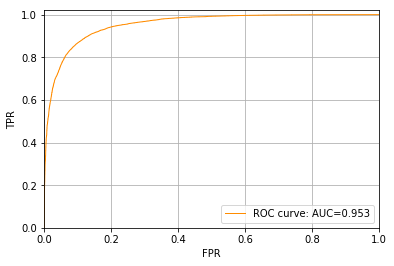

In [17]:
evaluate(y_test, proba)